In [29]:
import math
import numpy as np
import pandas as pd
import pints
import matplotlib.pyplot as plt
import os
plt.rcParams.update({'font.size': 24})
from one_step_model_numba import wrappedOneStepModel, oneStepModel

In [30]:
data_name = '9_2b_cv_current_reduced_0'
file_name = data_name + '.txt'
folder = os.path.join('Data', 'processed')
folder = os.path.join(folder, '220415')
folder = os.path.join(folder, 'ph4 2m nacl 25oC')
folder = os.path.join(folder, 'ac')
folder = os.path.join(folder, '9_2b')
data_file = os.path.join(folder, 'experimental')
data_file = os.path.join(data_file, file_name)

 # opening data
experimental_data = pd.read_csv(data_file, sep='\t')

exp_times = np.asarray(experimental_data.time)
exp_current = np.asarray(experimental_data.current)

inital_current = exp_current[0]
freq = 8.977950e+00
startPotential= -50.0E-3
revPotential = -650.0E-3
rateOfPotentialChange = -22.35174e-3

deltaepislon = 150.0E-3
electrode_area = 0.03
electode_coverage = 6.5e-12

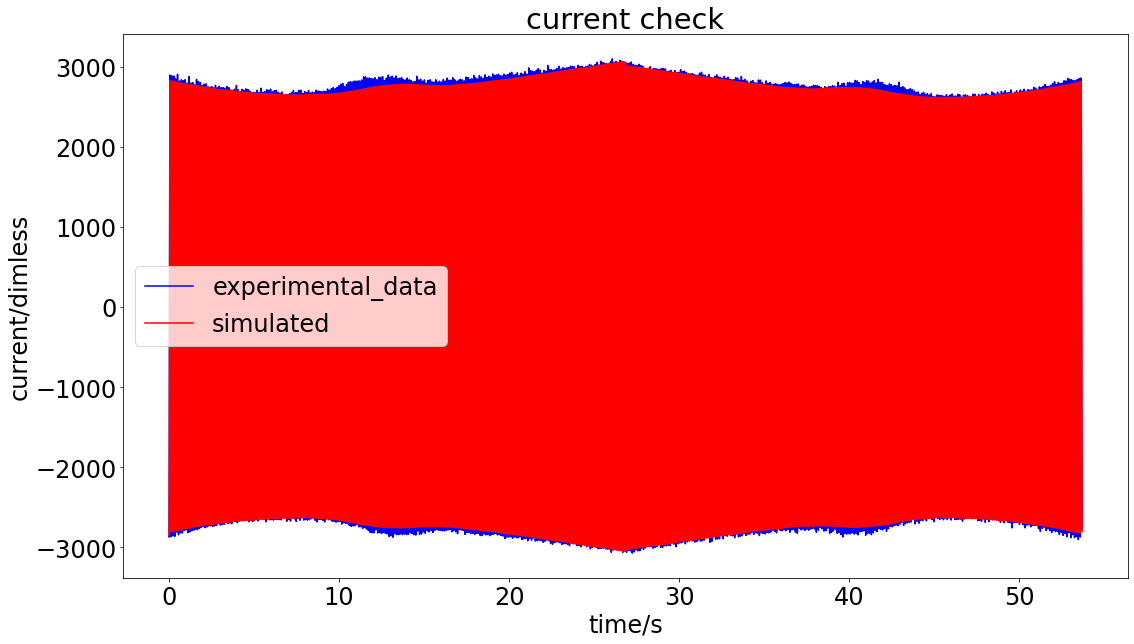

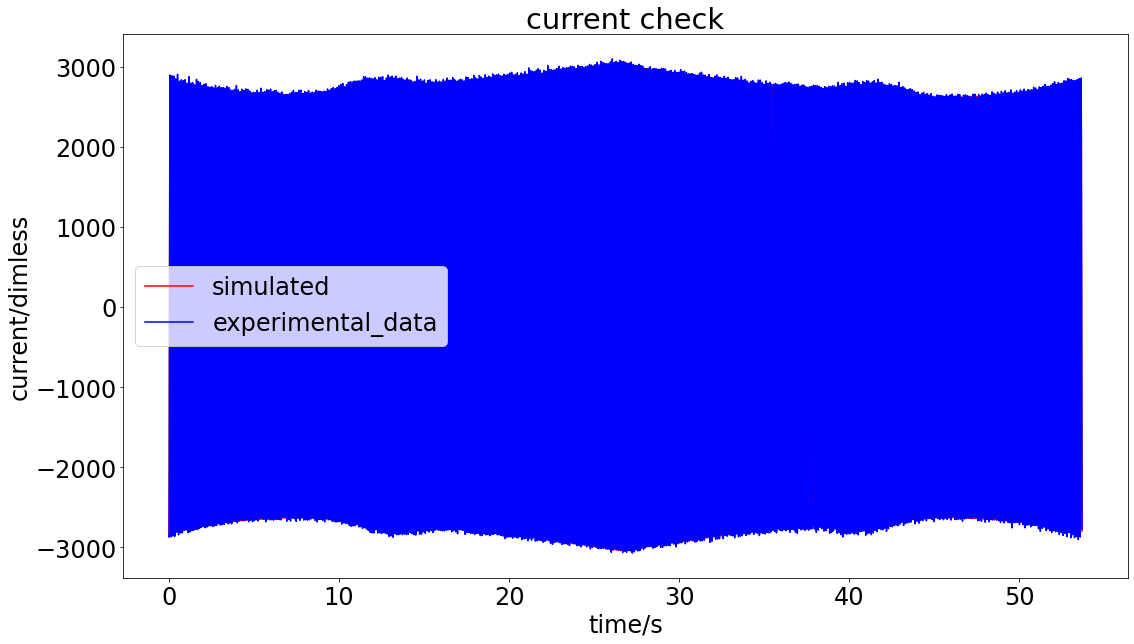

In [31]:
# delacring capactiance parameters
# (gamma0, gamma1, gamma2, gamma3, omega)
cap_params = [1.88356619214717408e-04,  1.61804383686788055e-04,  4.17733377707711021e-04,  2.26950957654291222e-04,
1.89087025059347230e-04,  1.73822423095618128e-04,  4.40681848741801942e-04,  2.44766711704709917e-04,
5.62930605707417087e+01]
uncomp_resis = 1.47087801383658210e+01

measurements = exp_current.shape[0]

# print('measurements: ', measurements)
# if measurements%2 !=0:
#     print('*'*30+'\nerror must have evennumber of measurments\n'+'*'*40)
# declaring model to obtain non dimensinalise constant
trial = oneStepModel(timeStepSize=exp_times[1], inital_current=inital_current, freq=freq, startPotential= startPotential, revPotential = revPotential,
                            rateOfPotentialChange = rateOfPotentialChange, numberOfMeasurements = measurements, deltaepislon=deltaepislon,
                            uncomp_resis=uncomp_resis, electrode_area=electrode_area, electode_coverage=electode_coverage)

# non-diming experimental data
exp_current_dimless = exp_current/trial.I0

# model for optimsation
model = wrappedOneStepModel(times = exp_times, inital_current=inital_current, freq=freq, startPotential= startPotential,
                            revPotential = revPotential, rateOfPotentialChange = rateOfPotentialChange, deltaepislon=deltaepislon,
                            uncomp_resis=uncomp_resis, electrode_area=electrode_area, electode_coverage=electode_coverage,
                            initaldiscard = 0.035, enddiscard = 0.880, cap_params=cap_params)

real_parameters = [3.99999999980972461e+03, -3.42609041074403153e-01, -1.35644299333995688e-02,  4.84706238932189448e-01]

current_trace = model.simulate(real_parameters, exp_times)

xaxislabel = "time/s" # "potential/V"
plt.figure(figsize=(18,10))
plt.title("current check")
plt.ylabel("current/dimless")
plt.xlabel(xaxislabel)
plt.plot(exp_times, exp_current_dimless,'b', label='experimental_data')
plt.plot(exp_times, current_trace,'r', label='simulated')
plt.legend(loc='best')
plt.show()

xaxislabel = "time/s" # "potential/V"
plt.figure(figsize=(18,10))
plt.title("current check")
plt.ylabel("current/dimless")
plt.xlabel(xaxislabel)
plt.plot(exp_times, current_trace,'r', label='simulated')
plt.plot(exp_times, exp_current_dimless,'b', label='experimental_data')
plt.legend(loc='best')
plt.show()